## Tabular Playground Series

In [1]:
import pandas as pd
import numpy as np
import os

print(os.listdir())

['.ipynb_checkpoints', 'sample_submission.csv', 'submission.csv', 'tabular-playground-series-jul-2021.zip', 'test.csv', 'train.csv', '[TPS-JUL] XGBoost.ipynb']


In [2]:
train = pd.read_csv('train.csv')
train.head(3)

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1


### EDA

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7111 entries, 0 to 7110
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date_time               7111 non-null   object 
 1   deg_C                   7111 non-null   float64
 2   relative_humidity       7111 non-null   float64
 3   absolute_humidity       7111 non-null   float64
 4   sensor_1                7111 non-null   float64
 5   sensor_2                7111 non-null   float64
 6   sensor_3                7111 non-null   float64
 7   sensor_4                7111 non-null   float64
 8   sensor_5                7111 non-null   float64
 9   target_carbon_monoxide  7111 non-null   float64
 10  target_benzene          7111 non-null   float64
 11  target_nitrogen_oxides  7111 non-null   float64
dtypes: float64(11), object(1)
memory usage: 666.8+ KB


In [4]:
# targets
targets = ['target_carbon_monoxide','target_benzene','target_nitrogen_oxides']
# sensors
sensors = ['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']

### Scaling

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def sensors_dist(data, title):
    fig = plt.figure(figsize = (16, 8))

    ax1 = fig.add_subplot(2, 3, 1)
    ax1 = sns.histplot(data['sensor_1'])

    ax2 = fig.add_subplot(2, 3, 2)
    ax2 = sns.histplot(data['sensor_2'])

    ax3 = fig.add_subplot(2, 3, 3)
    ax3 = sns.histplot(data['sensor_3'])

    ax4 = fig.add_subplot(2, 3, 4)
    ax4 = sns.histplot(data['sensor_4'])

    ax5 = fig.add_subplot(2, 3, 5)
    ax5 = sns.histplot(data['sensor_5'])

    fig.suptitle(title, fontsize = 20)
    plt.show()

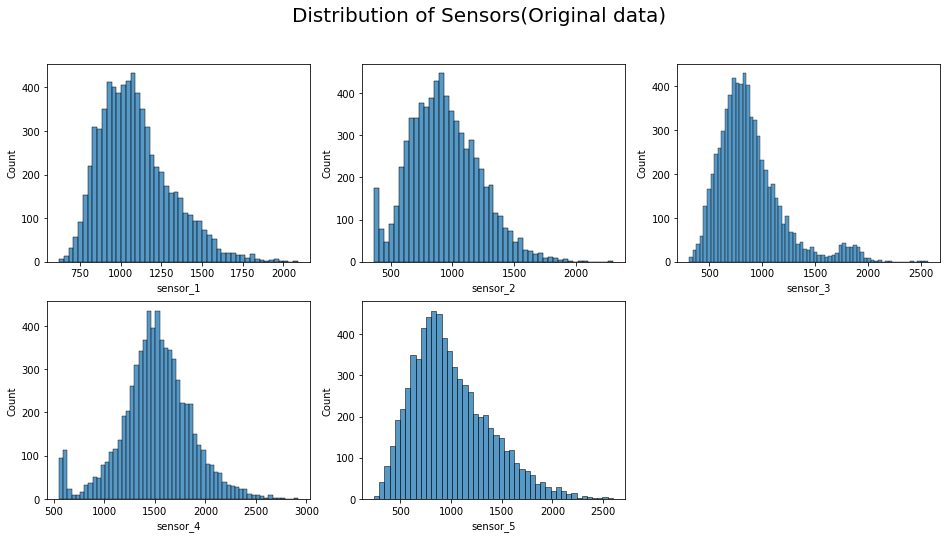

In [6]:
sensors_dist(train, "Distribution of Sensors(Original data)")

In [7]:
train.describe()[sensors].loc[['mean', 'std']]

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
mean,1091.572100,938.064970,883.903305,1513.238349,998.335565
std,218.537554,281.978988,310.456355,350.180310,381.537695


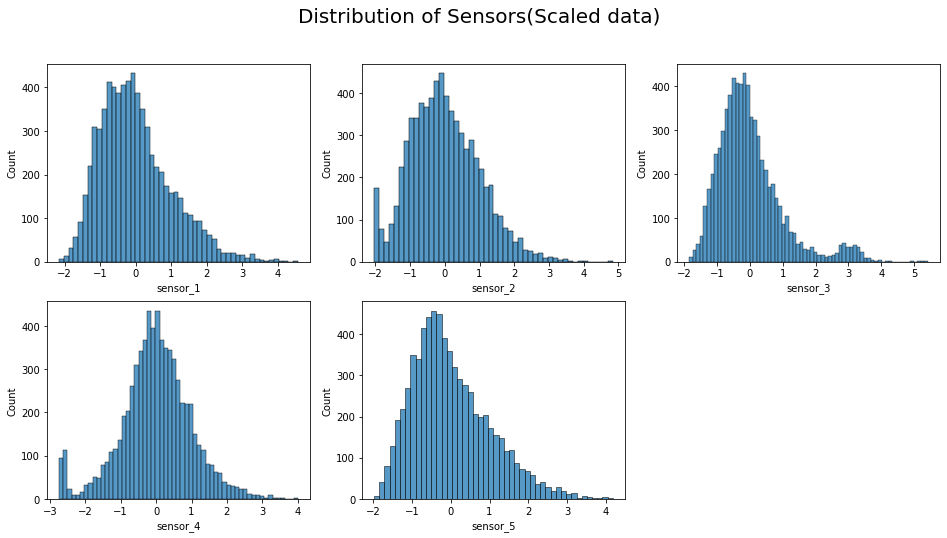

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
mean,0,0,0,0,0
std,1,1,1,1,1


In [8]:
# standard scaling
from sklearn.preprocessing import StandardScaler

train_1 = train.copy() # copy data before scaling
scalers = [] # 5 sensors -> 5 scalers
for se in sensors:
    std_scaler = StandardScaler()
    train_1[se] = std_scaler.fit_transform(np.array(train_1[se]).reshape(-1, 1))
    scalers.append(std_scaler)
sensors_dist(train_1, "Distribution of Sensors(Scaled data)")
train_1.describe()[sensors].loc[['mean', 'std']].astype("i")

### Feature Engineering

In [9]:
# transform time feature into numerical
from datetime import datetime

def get_weeknum(x):
    return datetime.strptime(x, "%Y-%m-%d %H:%M:%S").strftime("%V")
def get_hour(x):
    return datetime.strptime(x, "%Y-%m-%d %H:%M:%S").strftime("%H")

train_1['numOfWeek'] = train_1['date_time'].apply(lambda x: get_weeknum(x)).astype('int')
train_1['hour'] = train_1['date_time'].apply(lambda x: get_hour(x)).astype('int')
train_1.drop(['date_time'], axis = 1, inplace = True)
train_1.tail(3)

,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides,numOfWeek,hour
7108,9.6,34.6,0.4310,-0.215869,-0.605637,-0.070879,-1.782174,0.421389,1.6,5.2,227.4,52,22
7109,8.0,40.7,0.4085,-0.635048,-0.873052,0.079233,-1.702781,0.545108,1.5,4.6,199.8,52,23
7110,8.0,41.3,0.4375,0.078838,-0.682244,-0.279619,-1.808448,0.720201,1.4,4.1,186.5,52,0


### Data Preparation(for baseline modeling)

In [10]:
# data preparation
# task : predict next 24 hours 
train_data = train_1[:-24]
valid_data = train_1.tail(24)

x_train = train_data.drop(targets, axis = 1)
y_train = train_data[targets]

x_valid = valid_data.drop(targets, axis = 1)
y_valid = valid_data[targets]

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(7087, 10)
(7087, 3)
(24, 10)
(24, 3)


#### 01. XGBoost

In [19]:
import xgboost as xgb
import random

def make_xgb_dmatrix(feat:pd.DataFrame = None, 
                     label:pd.DataFrame = None,
                     test : bool = False,
                     targets:list = None):
    if not test:
        mats = []
        for t in targets:
            dmat = xgb.DMatrix(feat, label = label[t])
            mats.append(dmat)
        return mats
    else:
        return xgb.DMatrix(feat)

dtrains = make_xgb_dmatrix(feat = x_train, label = y_train, test = False, targets = targets)
dtests = make_xgb_dmatrix(feat = x_valid, label = y_valid, test = False, targets = targets)
models = []

In [20]:
for i, (dtrain, dtest) in enumerate(zip(dtrains, dtests)):
    print("####### {:30} training #########".format(targets[i]))
    param = {
        "objective" : "reg:squaredlogerror",
        "eval_metric" : "rmsle",
        "seed" : random.randint(1, 10000)
    }
    eval_list = [(dtest, "eval"), (dtrain, "train")]
    num_round = 100
    model = xgb.train(param, dtrain, num_round, eval_list, early_stopping_rounds = 10, verbose_eval = 10)
    models.append(model)

####### target_carbon_monoxide         training #########
[0]	eval-rmsle:0.29926	train-rmsle:0.65663
[10]	eval-rmsle:0.08197	train-rmsle:0.14113
[20]	eval-rmsle:0.08225	train-rmsle:0.09757
[30]	eval-rmsle:0.09342	train-rmsle:0.08925
[40]	eval-rmsle:0.10163	train-rmsle:0.08550
[50]	eval-rmsle:0.11404	train-rmsle:0.08055
[60]	eval-rmsle:0.12435	train-rmsle:0.07667
[70]	eval-rmsle:0.12670	train-rmsle:0.07346
[80]	eval-rmsle:0.11986	train-rmsle:0.06981
[90]	eval-rmsle:0.11962	train-rmsle:0.06739
[99]	eval-rmsle:0.11944	train-rmsle:0.06570
####### target_benzene                 training #########
[0]	eval-rmsle:1.05431	train-rmsle:1.75555
[10]	eval-rmsle:0.15879	train-rmsle:0.49978
[20]	eval-rmsle:0.10301	train-rmsle:0.13097
[30]	eval-rmsle:0.10543	train-rmsle:0.09764
[40]	eval-rmsle:0.10427	train-rmsle:0.09180
[50]	eval-rmsle:0.10460	train-rmsle:0.08886
[60]	eval-rmsle:0.10825	train-rmsle:0.08702
[70]	eval-rmsle:0.10820	train-rmsle:0.08538
[80]	eval-rmsle:0.10877	train-rmsle:0.08296
[90]	e

In [21]:
# evaluation
from sklearn.metrics import mean_squared_log_error as msle
scores = []

for i, dtest in enumerate(dtests):
    ypred = models[i].predict(dtest)
    score = np.sqrt(msle(y_valid[targets[i]].values, ypred))
    scores.append(score)
    print("RMSLE of {} : {:.2f}".format(targets[i], score))
print("Average RMSLE of targets : ", np.mean(scores))

RMSLE of target_carbon_monoxide : 0.12
RMSLE of target_benzene : 0.11
RMSLE of target_nitrogen_oxides : 0.69
Average RMSLE of targets :  0.3057407849960603


In [22]:
# submission format
sub = pd.read_csv("sample_submission.csv")
sub.head()

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,2.0,10.0,300.0
1,2011-01-01 01:00:00,2.0,10.0,300.0
2,2011-01-01 02:00:00,2.0,10.0,300.0
3,2011-01-01 03:00:00,2.0,10.0,300.0
4,2011-01-01 04:00:00,2.0,10.0,300.0


In [23]:
# predict bn test data
test = pd.read_csv("test.csv")

In [24]:
# scale on fitted scalers(sensors)
for i, se in enumerate(scalers):
    test[sensors[i]] = se.transform(test[sensors[i]].values.reshape(-1, 1))
    
test['numOfWeek'] = test['date_time'].apply(lambda x: get_weeknum(x)).astype('int')
test['hour'] = test['date_time'].apply(lambda x: get_hour(x)).astype('int')
test.drop(['date_time'], axis = 1, inplace = True)
test.head(3)

,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,numOfWeek,hour
0,8.0,41.3,0.4375,0.078838,-0.682244,-0.279619,-1.808448,0.720201,52,0
1,5.1,51.7,0.4564,0.722709,-0.259488,-0.631384,-1.543423,1.875869,52,1
2,5.8,51.5,0.4689,0.050466,-0.213027,-0.612700,-1.631669,0.792807,52,2


In [25]:
dtest = make_xgb_dmatrix(test, test = True)

for i, target in enumerate(targets):
    pred = models[i].predict(dtest)
    sub[target] = pred
sub.head()

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,1.057583,5.798122,111.596016
1,2011-01-01 01:00:00,1.733540,8.007839,116.739510
2,2011-01-01 02:00:00,1.468240,7.492241,116.739510
3,2011-01-01 03:00:00,1.613795,8.101520,116.739510
4,2011-01-01 04:00:00,1.234364,6.334759,116.739510


In [26]:
sub.to_csv("submission.csv", index = False) # 0.51975